In [3]:
import numpy as np
from numpy.ma.extras import MAxisConcatenator
import skrf as rf
import matplotlib.pyplot as plt
from skrf.media import Coaxial
from skrf.constants import K_BOLTZMANN, h_PLANK
import pandas as pd
from scipy.interpolate import interp1d
from scipy import optimize
from skrf.noisyComponents import Attenuator, Circulator
import os
import glob


In [81]:
###################################################################################################################
# Function to return linear NF from covariance matrix
###################################################################################################################
def return_nf(port, noise_ntwk):
    #Currently must be a two port device

    I = np.identity(np.shape(noise_ntwk.s)[1])
    I[port-1,port-1] = np.zeros_like(noise_ntwk.cs[0,port-1,port-1],dtype=float)
    AS = np.matmul(I, np.conjugate(noise_ntwk.s.swapaxes(1, 2)))
    SAS = np.matmul(noise_ntwk.s, AS)
    F2 = 1 +  np.real(noise_ntwk.cs[:,port-1,port-1]) / (K_BOLTZMANN*290*SAS[:,port-1,port-1])

    return F2

######################################################################################################################
## Function to make passive devices into noisy networks
######################################################################################################################
# def read_in_noisy_netowrk(file_path,file_name,freq_interp,Tphys):
#     file_loc = os.path.join(file_path,file_name)
#     file_net = rf.Network(file_loc)
#     file_net_interp = file_net.interpolate(freq_interp, kind='cubic')
#     file_net_interp_noisy = rf.NoisyNetwork(file_net_interp)
#     file_net_interp_noisy.noise_source(source='passive',T0 = Tphys)

#     return file_net_interp_noisy

####################################################################################################################
## functions to simulate ZX60-83LN-S+ 
####################################################################################################################

def gen_amp_S_NF_func(ZX60_83LN_NF_loc):
    noise_figure_data2 = pd.read_csv(ZX60_83LN_NF_loc  , header = None)
    noise_figure_data2[3] = 10**(noise_figure_data2[1]/10)
    NF_Func2 = interp1d(noise_figure_data2[0],noise_figure_data2[3],fill_value=1000)

    return NF_Func2

def return_amp_params(Amp_path,NF_path,freq_any,sat_check = False, vendor = True, Temp = 290):
   
    Tphys = Temp

    amp_sparam = rf.Network(Amp_path)
    amp_sparam = amp_sparam.interpolate(freq_any, kind='cubic')
    amp_sparam = rf.NoisyNetwork(amp_sparam)
    amp_sparam.noise_source(source='passive',T0 = Tphys) # why is this passive?
    
    try:
        NF_func = gen_amp_S_NF_func(NF_path)
        #nfig = NF_func(freq.f/1e9)
        nfig=NF_func(freq_any.f/1e9)
        print((nfig), 'bing',np.shape(nfig))
    except:
        print('error')

    Tnoise = rf.NetworkNoiseCov.Tnoise(freq_any.f,Tphys)

    
    I = np.identity(np.shape(amp_sparam.s)[1]) 
    AS = np.matmul(I, np.conjugate(amp_sparam.s.swapaxes(1, 2)))
    SAS = np.matmul(amp_sparam.s, AS)

    amp_sparam.cs[:,0,0] = (nfig-1) * K_BOLTZMANN * 290 * SAS[:,0,0]

    I = np.identity(np.shape(amp_sparam.s)[1])
    AS = np.matmul(I, np.conjugate(amp_sparam.s.swapaxes(1, 2)))
    SAS = np.matmul(amp_sparam.s, AS)

    amp_sparam.cs[:,1,1] = (nfig-1) * K_BOLTZMANN * 290* SAS[:,1,1]

    amp_sparam.cs[:,0,1] = np.zeros_like(amp_sparam.cs[:,1,1])
    amp_sparam.cs[:,1,0] = amp_sparam.cs[:,0,1]  
    
    return amp_sparam


In [63]:
NF_func = gen_amp_S_NF_func('../../../../data/LNF-LNC16_28WB_noisetemperature_datasheet.csv')
print(NF_func(freq_meg.f/1e9))

    

[8.95985104 8.99708836 9.03432567 ... 4.71008212 4.71015423 4.71022634]


In [5]:
def read_in_noisy_netowrk(file_path,file_name,freq_interp,Tphys):
    file_loc = os.path.join(file_path,file_name)
    file_net = rf.Network(file_loc)
    file_net_interp = file_net.interpolate(freq_interp, kind='cubic')
    file_net_interp_noisy = rf.NoisyNetwork(file_net_interp)
    # file_net_interp_noisy = rf.NoisyNetwork(file_net)
    file_net_interp_noisy.noise_source(source='passive',T0 = Tphys)

    return file_net_interp_noisy

In [82]:
freq1 = rf.frequency.Frequency(start=2, stop=6, npoints=2000, unit='ghz', sweep_type='lin')
print(freq)
freq_meg = rf.frequency.Frequency(start=20, stop=27, npoints=2001, unit='ghz', sweep_type='lin')
print(freq_meg)
#confused about the start and stop


comp_path='../../../../data/'
#comp_path='\\..\\..\\..\\..\\data\\'
print(comp_path)
##not convinced we need a comp path
#also I think im kinda hard coding rn sorry


attn=rf.Network('../../../../data/KAT-20+_Plus25DegC_Unit1.s2p',f_unit='Hz')

attn_290k=read_in_noisy_netowrk(comp_path,'KAT-20+_Plus25DegC_Unit1.s2p',freq_meg,290)

attn_580k=read_in_noisy_netowrk(comp_path,'KAT-20+_Plus25DegC_Unit1.s2p',freq_meg,290*2)
attn_29k=read_in_noisy_netowrk(comp_path,'KAT-20+_Plus25DegC_Unit1.s2p',freq_meg,29)

amplifier_path='../../../../data/ZX60-83LN-S+_AP160503_060216_RFPARAM_Unit1.s2p'
amplifier_NF_path='../../../../data/ZX60_83LN_NF.csv'
amp_path_meg='../../../../data/LNF-LNC16_28WB_sn149Z_Vd=1.6V_Id=40.0mA_rt-spar_1.s2p'
amplifier_NF_path_meg='../../../../data/LNF-LNC16_28WB_noisetemperature_datasheet.csv'

amp_meg=return_amp_params(amp_path_meg,amplifier_NF_path_meg,freq_meg,sat_check = False, vendor = True, Temp = 29)

amplifier_29k=return_amp_params(amplifier_path,amplifier_NF_path,freq1, sat_check = False, vendor = True, Temp = 29)
amplifier_290k=return_amp_params(amplifier_path,amplifier_NF_path,freq1, sat_check = False, vendor = True, Temp = 290)
amplifier_580k=return_amp_params(amplifier_path,amplifier_NF_path,freq1, sat_check = False, vendor = True, Temp = 580)
print(amp_meg)

2.0-6.0 GHz, 2001 pts
20.0-27.0 GHz, 2001 pts
../../../../data/
[ 4.71022634  4.71035254  4.71047873 ... 11.87285372 11.85599946
 11.8391452 ] bing (2001,)
[1.36383511 1.36378993 1.36374475 ... 1.42649837 1.426525   1.42655164] bing (2000,)
[1.36383511 1.36378993 1.36374475 ... 1.42649837 1.426525   1.42655164] bing (2000,)
[1.36383511 1.36378993 1.36374475 ... 1.42649837 1.426525   1.42655164] bing (2000,)
2-Port NoisyNetwork: 'LNF-LNC16_28WB_sn149Z_Vd=1.6V_Id=40.0mA_rt-spar_1',  20.0-27.0 GHz, 2001 pts, z0=[50.+0.j 50.+0.j]


(19.701675118849526, 33.600782760829894)

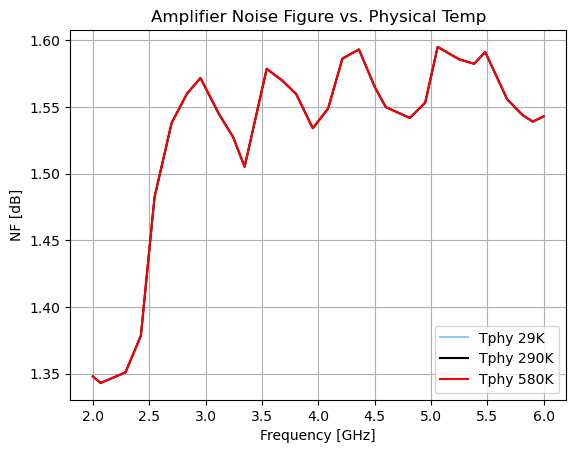

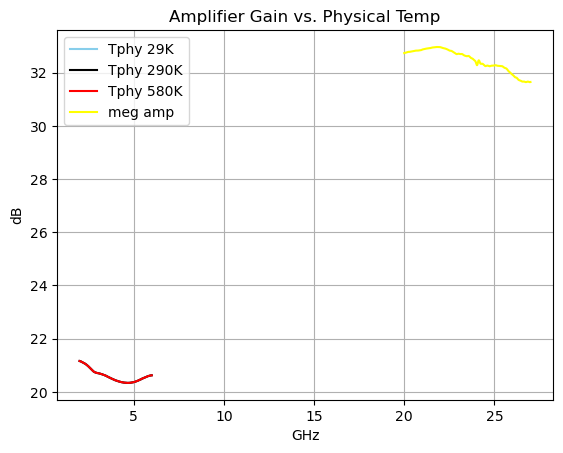

In [84]:


plt.figure()
plt.plot(freq1.f/1e9,10*np.log10(return_nf(2,amplifier_29k)),color='skyblue', label='Tphy 29K')
plt.plot(freq1.f/1e9,10*np.log10(return_nf(2,amplifier_290k)),color='k', label='Tphy 290K')
plt.plot(freq1.f/1e9,10*np.log10(return_nf(2,amplifier_580k)),color='r', label='Tphy 580K')
plt.legend()
plt.grid()
plt.title('Amplifier Noise Figure vs. Physical Temp')
plt.xlabel('Frequency [GHz]')
plt.ylabel('NF [dB]')


plt.figure()
plt.plot(amplifier_29k.f/1e9,20*np.log10(np.abs(amplifier_29k.s[:,1,0])),color='skyblue',label='Tphy 29K')
plt.plot(amplifier_290k.f/1e9,20*np.log10(np.abs(amplifier_290k.s[:,1,0])),color='k',label='Tphy 290K')
plt.plot(amplifier_580k.f/1e9,20*np.log10(np.abs(amplifier_580k.s[:,1,0])),color='r',label='Tphy 580K')
plt.plot(amp_meg.f/1e9,20*np.log10(np.abs(amp_meg.s[:,1,0])),color='yellow',label='meg amp')

plt.ylabel('dB')
plt.xlabel('GHz')
plt.legend(loc='best')
plt.title('Amplifier Gain vs. Physical Temp')
plt.grid()
plt.ylim()

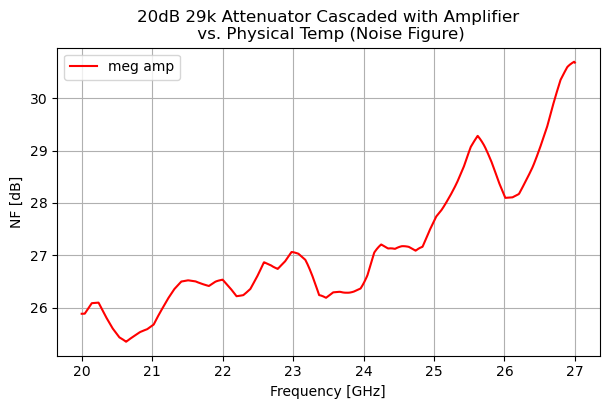

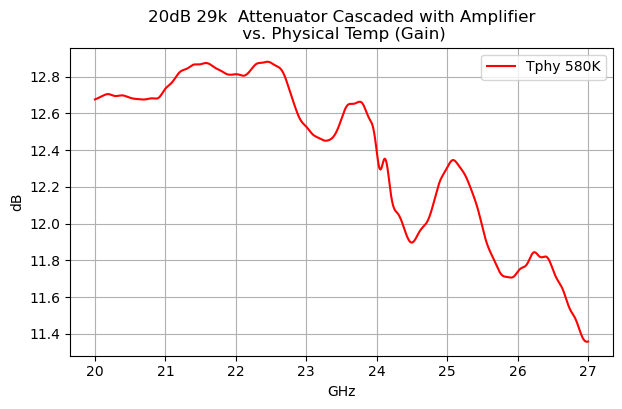

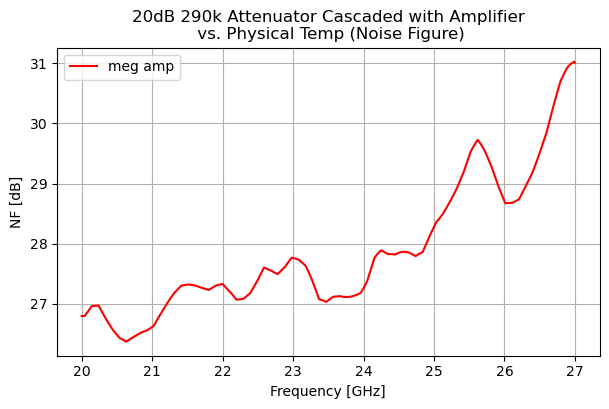

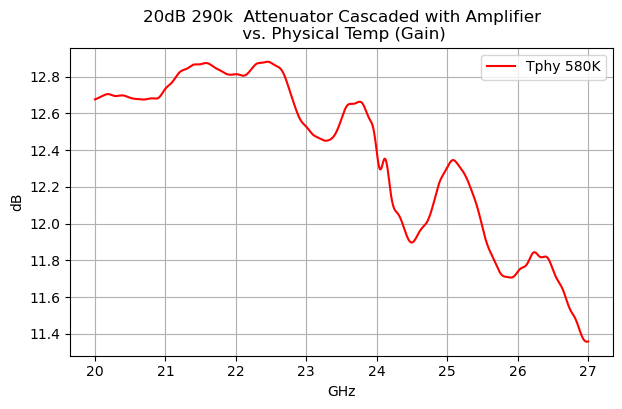

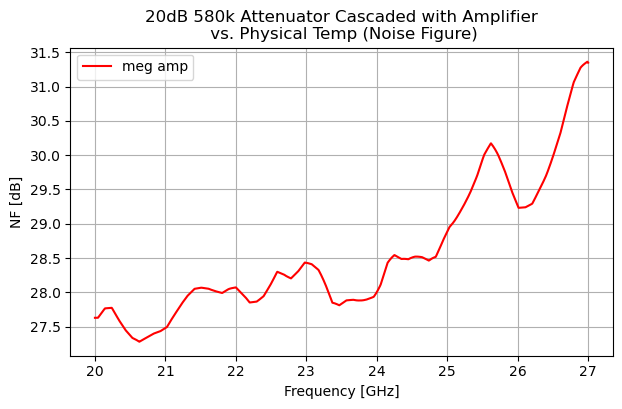

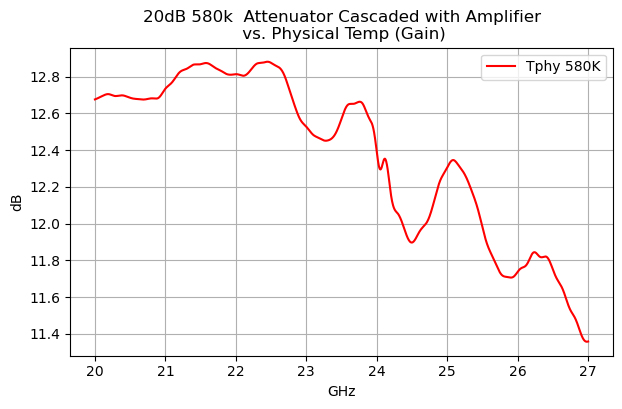

In [79]:

attns=[attn_29k,attn_290k,attn_580k]
attns_name=['29k','290k','580k']
for n in range(len(attns)):
    
    '''
    Case 2, Cascading Attenuator with Amplifiers for Noise Figure Calculations
    '''
    Attn_to_29kAmp=rf.noisyNetwork.cascade_2port(attns[n],amplifier_29k,True)
    
    Attn_to_290kAmp=rf.noisyNetwork.cascade_2port(attns[n],amplifier_290k,True)
    
    Attn_to_580kAmp=rf.noisyNetwork.cascade_2port(attns[n],amplifier_580k,True)

    Attn_to_megAmp=rf.noisyNetwork.cascade_2port(attns[n],amp_meg,True)

    
    plt.figure(figsize=(7,4))
    # plt.plot(freq.f/1e9,10*np.log10(return_nf(2,Attn_to_29kAmp)),color='skyblue', label='Amp Tphy 29K')
    # plt.plot(freq.f/1e9,10*np.log10(return_nf(2,Attn_to_290kAmp)),color='k', label='Amp Tphy 290K')
    # plt.plot(freq.f/1e9,10*np.log10(return_nf(2,Attn_to_580kAmp)),color='r', label='Amp Tphy 580K')
    plt.plot(freq_meg.f/1e9,10*np.log10(return_nf(2,Attn_to_megAmp)),color='r', label='meg amp')
    plt.legend()
    plt.grid()
    plt.title('20dB '+attns_name[n]+' Attenuator Cascaded with Amplifier\n vs. Physical Temp (Noise Figure)')
    plt.xlabel('Frequency [GHz]')
    plt.ylabel('NF [dB]')
    
    
    plt.figure(figsize=(7,4))
    # plt.plot(Attn_to_29kAmp.f/1e9,20*np.log10(np.abs(Attn_to_29kAmp.s[:,1,0])),color='skyblue',label='Tphy 29K')
    # plt.plot(Attn_to_290kAmp.f/1e9,20*np.log10(np.abs(Attn_to_290kAmp.s[:,1,0])),color='k',label='Tphy 290K')
    # plt.plot(Attn_to_580kAmp.f/1e9,20*np.log10(np.abs(Attn_to_580kAmp.s[:,1,0])),color='r',label='Tphy 580K')
    plt.plot(Attn_to_megAmp.f/1e9,20*np.log10(np.abs(Attn_to_megAmp.s[:,1,0])),color='r',label='Tphy 580K')
    
    plt.ylabel('dB')
    plt.xlabel('GHz')
    plt.legend(loc='best')
    plt.title('20dB '+attns_name[n]+'  Attenuator Cascaded with Amplifier\n vs. Physical Temp (Gain)')
    plt.grid()
    plt.ylim()
























